In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pylab as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from Preprocessing2 import Signal_process, Stat_process 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from icecream import ic 
from scipy import signal
import pickle
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, MaxPooling1D, UpSampling2D,Conv2DTranspose, Flatten, Reshape, Concatenate, AveragePooling2D
from tensorflow.keras.layers import UpSampling2D,Conv2DTranspose, Flatten, Reshape, Concatenate, AveragePooling2D, MaxPooling1D, Conv1D, Conv1DTranspose
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Dropout, concatenate
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.utils import get_custom_objects
from tensorflow import keras
from tensorflow.keras import callbacks as cb

tf.random.set_seed(121)

In [3]:
with open('statistic.pickle', 'rb') as f:
    statistic = pickle.load(f)
    
with open('signal_minmax.pickle', 'rb') as f:
    signal = pickle.load(f)

In [6]:
statistic[0].shape

(100, 50, 10, 16)

In [8]:
signal[0].shape

(100, 500, 16)

In [9]:
train_ratio = 0.8
train_index = []
validation_index = []

for i in range(4):
    N = len(statistic[i])
    ratio = int(train_ratio * N)
    indices = np.random.permutation(statistic[i].shape[0])
    train_idx, val_idx = indices[:ratio], indices[ratio:]
    
    train_index.append(train_idx)
    validation_index.append(val_idx)

In [10]:
train_stat = []
train_signal = []
val_stat = []
val_signal = []

for i in range(4):
    train_stat_temp, val_stat_temp = statistic[i][train_index[i]], statistic[i][validation_index[i]]
    train_signal_temp, val_signal_temp = signal[i][train_index[i]], signal[i][validation_index[i]]
    
    train_stat.append(train_stat_temp)
    val_stat.append(val_stat_temp)
    
    train_signal.append(train_signal_temp)
    val_signal.append(val_signal_temp)

In [11]:
train_signal[0].shape

(80, 500, 16)

In [15]:
win_length = 25
train_signal[0] = train_signal[0].reshape(-1,win_length,16)
train_signal[1] = train_signal[1].reshape(-1,win_length,16)
train_signal[2] = train_signal[2].reshape(-1,win_length,16)
train_signal[3] = train_signal[3].reshape(-1,win_length,16)

val_signal[0] = val_signal[0].reshape(-1,win_length,16)
val_signal[1] = val_signal[1].reshape(-1,win_length,16)
val_signal[2] = val_signal[2].reshape(-1,win_length,16)
val_signal[3] = val_signal[3].reshape(-1,win_length,16)

In [16]:
X = np.concatenate(train_signal)
val_X = np.concatenate(val_signal)

In [52]:
print(X.shape)
print(val_X.shape)

(11340, 25, 16)
(2840, 25, 16)


In [53]:
y = []
for D in signal:
    N = D.shape[0]
    label = np.array(list(np.linspace(0,1,20))*N).reshape(-1,20)
    y.append(label)

Y = np.concatenate(y).reshape(-1,1)[:11340]
val_Y = np.concatenate(y).reshape(-1,1)[:2840]

In [ ]:
train_stat[0] = train_stat[0].reshape(-1,10,16)
train_stat[1] = train_stat[1].reshape(-1,10,16)
train_stat[2] = train_stat[2].reshape(-1,10,16)
train_stat[3] = train_stat[3].reshape(-1,10,16)

val_stat[0] = val_stat[0].reshape(-1,10,16)
val_stat[1] = val_stat[1].reshape(-1,10,16)
val_stat[2] = val_stat[2].reshape(-1,10,16)
val_stat[3] = val_stat[3].reshape(-1,10,16)

X1 = np.concatenate(train_stat)
val_X1 = np.concatenate(val_stat)

In [182]:
X.shape

(28350, 10, 16)

In [56]:
def FEAE():
    '''Autoencoder part'''   
       
    '''signal AE'''
    signal_inputs = Input(shape = (win_length, 16), name = 'signal_inputs')
    z = Conv1D(filters=8, kernel_size=10, padding='same', activation='tanh')(signal_inputs)
   #z = MaxPooling1D(5)(z)
    z = Conv1D(filters=4, kernel_size=5, padding='same', activation='tanh')(z)
    z = Conv1D(filters=1, kernel_size=5, padding='same', activation='tanh')(z)
    z = MaxPooling1D(5)(z)
    
    latent_z = Flatten(name = 'latent_z')(z)
    z = Reshape((5,1))(latent_z)
    
    z = Conv1DTranspose(filters = 1, kernel_size=5, strides=5, padding='same', activation='elu')(z)
    z = Conv1D(filters=4, kernel_size=5, padding='same', activation='tanh')(z)
    z = Conv1D(filters=8, kernel_size=10, padding='same', activation='tanh')(z)  
    z = Conv1D(filters=16, kernel_size=15, padding='same', name='signal_AE', activation='relu')(z) 
    
#     '''RUL part'''
#     latent_stat = Dense(6, activation='tanh')(latent_x) 
    latent_signal = Dense(3, activation='tanh')(latent_z)    
    #latent_fft = Dense(4, activation='tanh')(latent_z)

#     concat = concatenate([latent_stat, latent_signal, latent_fft])
    #h = Dense(4, activation='tanh')(latent_fft)
    h = Dense(1, activation='tanh', name = 'RUL_OUTPUT')(latent_signal)
    
#     model = Model([stat_inputs, signal_inputs, fft_inputs], [x, y, z, h])
#     #print(model.summary())
    model = Model(signal_inputs, [z,h])
    #model = Model(stat_inputs, [z, h])
    return model

In [57]:
model = FEAE()
model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True)

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
signal_inputs (InputLayer)      [(None, 25, 16)]     0                                            
__________________________________________________________________________________________________
conv1d_46 (Conv1D)              (None, 25, 8)        1288        signal_inputs[0][0]              
__________________________________________________________________________________________________
conv1d_47 (Conv1D)              (None, 25, 4)        164         conv1d_46[0][0]                  
__________________________________________________________________________________________________
conv1d_48 (Conv1D)              (None, 25, 1)        21          conv1d_47[0][0]                  
___________________________________________________________________________________________

In [58]:
model.compile(optimizer = keras.optimizers.Adam(lr = 0.00001), loss = 'mse')

In [59]:
import time
start = time.time()

reduce_lr = cb.ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=1e-6,
                                 patience=5, cooldown=25, min_delta=0, verbose=1)

early_stop = cb.EarlyStopping(monitor='val_loss', patience=8, min_delta=0)

callbacks = [early_stop, reduce_lr]


hist = model.fit(x = X,
                 y = {'signal_AE':X,
                      'RUL_OUTPUT':Y},
                 validation_data = (val_X, [val_X, val_Y]),
                       epochs = 2000,
                       batch_size = 64,
                       callbacks=callbacks)

#combination.save_weights(MODEL_SAVE_DIR_PATH + 'last_version.hdf5')

Epoch 1/2000
178/178 [==============================] - 2s 5ms/step - loss: 0.8914 - signal_AE_loss: 0.2982 - RUL_OUTPUT_loss: 0.5933 - val_loss: 0.7366 - val_signal_AE_loss: 0.3023 - val_RUL_OUTPUT_loss: 0.4342
Epoch 2/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.6966 - signal_AE_loss: 0.2987 - RUL_OUTPUT_loss: 0.3978 - val_loss: 0.5850 - val_signal_AE_loss: 0.3025 - val_RUL_OUTPUT_loss: 0.2825
Epoch 3/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.5694 - signal_AE_loss: 0.2997 - RUL_OUTPUT_loss: 0.2697 - val_loss: 0.4987 - val_signal_AE_loss: 0.2979 - val_RUL_OUTPUT_loss: 0.2008
Epoch 4/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.4877 - signal_AE_loss: 0.2944 - RUL_OUTPUT_loss: 0.1933 - val_loss: 0.4495 - val_signal_AE_loss: 0.2901 - val_RUL_OUTPUT_loss: 0.1594
Epoch 5/2000
178/178 [==============================] - 1s 3ms/step - loss: 0.4420 - signal_AE_loss: 0.2851 - RUL_OUTPUT_loss: 0.1568 - val_loss: 0.4176

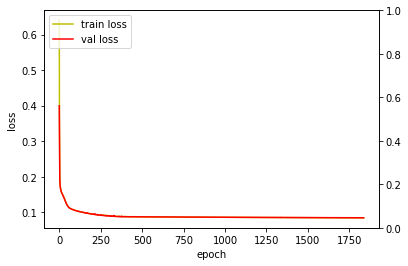

In [251]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')
plt.show()    

In [196]:
X.shape

(28350, 10, 16)

In [235]:
val_X.shape

(7100, 10, 16)

In [252]:
pre = model.predict(X)

In [213]:
pre = pre.reshape(-1,500,16)

In [217]:
train_signal[0].reshape(-1,500,16)

(4000, 10, 16)

In [ ]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr = 0.0005)
loss_list = {
    'STAT_AE':'mse',
    'SIGNAL_AE':'mse',
    'FFT_AE':'mse',
    'RUL_OUTPUT':'mse'
}
metric_list = [tf.losses.MeanAbsoluteError(), 
               tf.keras.metrics.RootMeanSquaredError(), 
               ]

combination.compile(optimizer = keras.optimizers.Adam(), loss = loss_list, metrics = metric_list)

In [ ]:
import time
start = time.time()



MODEL_SAVE_DIR_PATH = '/home/yongkp/CAE_LSTM/CAE_RUL/Jupyter/model_save/stage1_model/'
if not os.path.exists(MODEL_SAVE_DIR_PATH):
    os.mkdir(MODEL_SAVE_DIR_PATH)

TENSORBOARD_SAVE_DIR_PATH = '/home/yongkp/CAE_LSTM/CAE_RUL/logs/stage1_model'
if not os.path.exists(TENSORBOARD_SAVE_DIR_PATH):
    os.mkdir(TENSORBOARD_SAVE_DIR_PATH)


model_path = MODEL_SAVE_DIR_PATH + '{epoch:03d}_{val_loss:.4f}.hdf5'
# 'dnn_checkpoint.h5'
reduce_lr = cb.ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=1e-6,
                                 patience=15, cooldown=25, min_delta=0, verbose=1)

early_stop = cb.EarlyStopping(monitor='val_loss', patience=30, min_delta=0)

checkpoint = cb.ModelCheckpoint(filepath=model_path,
                                save_weights_only=True,
                                save_best_only=True,
                                monitor='val_loss',
                                verbose=1)

log_dir = TENSORBOARD_SAVE_DIR_PATH
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [early_stop, checkpoint, reduce_lr, tensorboard]


hist = combination.fit(
    {'stat_inputs':train_stat,
    'signal_inputs':train_signal,
    'fft_inputs':train_fft},

    {'STAT_AE':train_stat,
     'SIGNAL_AE':train_signal,
     'FFT_AE':train_fft,
     'RUL_OUTPUT':y_train},

    epochs = 2000, batch_size = 32, shuffle=True, validation_split=0.2, callbacks=callbacks)

combination.save_weights(MODEL_SAVE_DIR_PATH + 'last_version.hdf5')